# Automatic sleep staging

This notebook demonstrates how to perform automatic sleep staging of polysomnography data in YASA. For more details, make sure to read the [eLife publication](https://elifesciences.org/articles/70092).

Please install the latest version of YASA first with: `pip install --upgrade yasa`.

In [1]:

import mne
from mne.io import read_raw_edf
from mne.filter import filter_data

import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import core
import os
import re
from datetime import datetime, timedelta
#import PyQt5

from scipy.signal import butter, filtfilt,savgol_filter,find_peaks,welch
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter

from scipy.stats import kurtosis
from sklearn.preprocessing import normalize

import argparse

/mnt/home/mkumar/miniconda3/envs/sleep/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/mnt/home/mkumar/miniconda3/envs/sleep/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Read command line arguments from scripts

In [2]:
parser=argparse.ArgumentParser()
parser.add_argument('--project_name', type=str)
parser.add_argument('--model', type=str)
#args= parser.parse_args()

_StoreAction(option_strings=['--model'], dest='model', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [3]:
## Inout variabels from a script

In [4]:
args = parser.parse_args(args=['--project_name', 'Dreem', '--model', 'YASA'])
print(args)

Namespace(project_name='Dreem', model='YASA')


In [5]:
print(args)
print(args.project_name, args.model)

Namespace(project_name='Dreem', model='YASA')
Dreem YASA


## Data loading

The automatic sleep staging function requires that the data are loaded using the [MNE Python package](https://mne.tools/stable/index.html). For instance, if your polysomnography data are stored in the standard European Data Fomat (.edf), you can use [this function](https://mne.tools/stable/generated/mne.io.read_raw_edf.html?highlight=read_raw_edf#mne.io.read_raw_edf) to load the data into Python.

In [9]:
from utilities import project_data_dir


In [18]:
data_folder = project_data_dir[args.project_name]
print(data_dir)

/mnt/ceph/users/mhacohen/data/Dreem


In [21]:
#data_folder ='/mnt/ceph/users/mhacohen/data/Dreem/'

#check folder
os.chdir(data_folder)

# Set directory path to where the EDF files are located
edf_dir = os.path.join(data_folder,'edf')
csv_dir = os.path.join(data_folder,'Ilan')


# Get list of EDF files in the directory
edf_files = [file for file in os.listdir(edf_dir) if (file.startswith('sfsleeproject_test01_')) | (file.startswith('sfsleeproject_test06_'))]
csv_files = [file for file in os.listdir(csv_dir) if (file.endswith(r'.csv') and not (file.endswith(r'fft.csv')))]

EEG = mne.io.read_raw_edf('/mnt/ceph/users/mhacohen/data/Dreem/edf/sfsleeproject_test01_2022-10-18T23-05-20[04-00].edf', preload=True)

#raw.set_eeg_reference('average', projection=True)

winlen = EEG.info['sfreq'] * 4
overlap = EEG.info['sfreq'] * 2

hzL = np.linspace(0, EEG.info['sfreq'] / 2, int(winlen / 2) + 1)  # frequencies for every window

channels = ['EEG F7-O1', 'EEG F8-O2','EEG F8-O1', 'EEG F7-O2']

# Select channels

delta = [0.75, 4]
theta = [4, 8]
alpha = [8, 12]
beta = [13, 20]
allfreq = [1, 20]
deltaidx = np.searchsorted(hzL, delta)
thetaidx = np.searchsorted(hzL, theta)
alphaidx = np.searchsorted(hzL, alpha)
betaidx = np.searchsorted(hzL, beta)
allfreqidx = np.searchsorted(hzL, allfreq)



Extracting EDF parameters from /mnt/ceph/users/mhacohen/data/Dreem/edf/sfsleeproject_test01_2022-10-18T23-05-20[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4544499  =      0.000 ... 18177.996 secs...


In [17]:
print(edf_dir)

/edf


In [31]:
df_file_descr=pd.DataFrame()
df_file_descr['Number']=np.NaN
df_file_descr['File_Name']=np.NaN
df_file_descr['Recording_Date']=np.NaN
df_file_descr['File_Date']=np.NaN



In [32]:
print(df_file_descr)

Empty DataFrame
Columns: [Number, File_Name, Recording_Date, File_Date]
Index: []


In [33]:
# Loop through each EDF file run filter and save staging
for edf_file,i in zip(edf_files,range(len(edf_files))):
    # Extract date information from the file name using regular expressions
    file_date = re.search(r'\d{4}-\d{2}-\d{2}', edf_file).group()
    file_date = datetime.strptime(file_date, '%Y-%m-%d').date()
    df_file_descr.loc[i,'Number'] = int(i)   
    df_file_descr.loc[i,'File_Date'] = file_date   
    df_file_descr.loc[i,'File_Name'] = edf_file  

    if file_date == datetime(2023, 5, 16).date():
        continue
    else:
        # Extract time from the time string
        file_time = re.search(r'\d{2}-\d{2}-\d{2}\[\d{2}-\d{2}\]', edf_file).group()
        file_time = file_time[:8]
        file_time = datetime.strptime(file_time, '%H-%M-%S').time()

        # Check if the time is greater than 19:00:00
        if file_time > datetime.strptime('19:00:00', '%H:%M:%S').time():
            file_date += timedelta(days=1)  # Add one day
        df_file_descr.loc[i,'Recording_Date'] = file_date   


        #print(f"EDF file {edf_file} was recorded on {file_date.strftime('%Y-%m-%d')}")

        # Load EDF file using MNE
        edf_path = os.path.join(edf_dir, edf_file)
        #EEG = mne.io.read_raw_edf(edf_path, preload=True,verbose=False)

        #EEG.pick_channels(channels)

        # Load stage file
        stagefile = f"dreem_id_{file_date.strftime('%Y_%m_%d')}.csv"
        if stagefile not in os.listdir(csv_dir):
            continue
        else:
            stage_path = os.path.join(csv_dir, stagefile)
            stages = pd.read_csv(stage_path)

            onset_timedeltas = pd.to_timedelta(stages['Time [hh:mm:ss]'])
            onset_seconds = onset_timedeltas.dt.total_seconds()

            # Convert stages dataframe to MNE annotations
            annotations = mne.Annotations(onset=onset_seconds,
                                         duration=stages['Duration[s]'].values,
                                         description=stages['Sleep Stage'].values)


            # Add variables to the dictionary with dynamic names
            locals()[f'eeg_id_{i}'] = EEG
            locals()[f'dreem_algo_id_{i}'] = stages



PermissionError: [Errno 13] Permission denied: '/mnt/ceph/users/mhacohen/data/Dreem/Ilan/dreem_id_2023_05_26.csv'

In [34]:
df_file_descr

,Number,File_Name,Recording_Date,File_Date
0,0.0,sfsleeproject_test06_2023-05-01T22-14-09[04-00...,2023-05-02,2023-05-01
1,1.0,sfsleeproject_test01_2022-11-27T00-23-07[05-00...,2022-11-27,2022-11-27
2,2.0,sfsleeproject_test01_2022-12-20T23-01-14[05-00...,2022-12-21,2022-12-20
3,3.0,sfsleeproject_test01_2023-01-21T00-38-10[05-00...,2023-01-21,2023-01-21
4,4.0,sfsleeproject_test01_2022-12-15T23-34-06[05-00...,2022-12-16,2022-12-15
5,5.0,sfsleeproject_test01_2022-11-08T23-20-19[05-00...,2022-11-09,2022-11-08
6,6.0,sfsleeproject_test01_2023-05-21T00-02-27[04-00...,2023-05-21,2023-05-21
7,7.0,sfsleeproject_test01_2023-01-16T23-52-15[05-00...,2023-01-17,2023-01-16
8,8.0,sfsleeproject_test01_2023-05-16T23-22-07[04-00...,NaN,2023-05-16
9,9.0,sfsleeproject_test01_2023-05-22T23-54-35[04-00...,2023-05-23,2023-05-22


In [ ]:
# Loop through each EDF file run filter and save staging
for edf_file,i in zip(edf_files,range(len(edf_files))):
    # Extract date information from the file name using regular expressions
    file_date = re.search(r'\d{4}-\d{2}-\d{2}', edf_file).group()
    file_date = datetime.strptime(file_date, '%Y-%m-%d').date()
              
    if file_date == datetime(2023, 5, 16).date():
        continue
    else:
        # Extract time from the time string
        file_time = re.search(r'\d{2}-\d{2}-\d{2}\[\d{2}-\d{2}\]', edf_file).group()
        file_time = file_time[:8]
        file_time = datetime.strptime(file_time, '%H-%M-%S').time()

        # Check if the time is greater than 19:00:00
        if file_time > datetime.strptime('19:00:00', '%H:%M:%S').time():
            file_date += timedelta(days=1)  # Add one day

        print(f"EDF file {edf_file} was recorded on {file_date.strftime('%Y-%m-%d')}")

        # Load EDF file using MNE
        edf_path = os.path.join(edf_dir, edf_file)
        EEG = mne.io.read_raw_edf(edf_path, preload=True,verbose=False)

        EEG.pick_channels(channels)

        # Load stage file
        stagefile = f"dreem_id_{file_date.strftime('%Y_%m_%d')}.csv"
        if stagefile not in os.listdir(csv_dir):
            continue
        else:
            stage_path = os.path.join(csv_dir, stagefile)
            stages = pd.read_csv(stage_path)

            onset_timedeltas = pd.to_timedelta(stages['Time [hh:mm:ss]'])
            onset_seconds = onset_timedeltas.dt.total_seconds()

            # Convert stages dataframe to MNE annotations
            annotations = mne.Annotations(onset=onset_seconds,
                                         duration=stages['Duration[s]'].values,
                                         description=stages['Sleep Stage'].values)


            # Add variables to the dictionary with dynamic names
            locals()[f'eeg_id_{i}'] = EEG
            locals()[f'dreem_algo_id_{i}'] = stages



EDF file sfsleeproject_test06_2023-05-01T22-14-09[04-00].edf was recorded on 2023-05-02
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EDF file sfsleeproject_test01_2022-11-27T00-23-07[05-00].edf was recorded on 2022-11-27
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EDF file sfsleeproject_test01_2022-12-20T23-01-14[05-00].edf was recorded on 2022-12-21
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EDF file sfsleeproject_test01_2023-01-21T00-38-10[05-00].edf was recorded on 2023-01-21
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EDF file sfsleeproject_test01_2022-12-15T23-34-06[05-00].edf was recorded on 2022-12-16
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EDF file sfsleeproject_test01_2022-11-08T23-20-19[05-00].edf was recorded on 2022-11-09
NOTE: pick_channels() is a legacy function. New code should use inst.pic

In [ ]:
i=0
eeg_variables = [var_name for var_name in locals() if var_name.startswith("eeg_")]
for eeg_variable in eeg_variables:
    eeg_value = locals()[eeg_variable]
    i +=1;
    print(eeg_value)
    sls = yasa.SleepStaging(eeg_value, eeg_name="EEG F7-O1")
    locals()[f'yasa_{i}'] = sls.predict()


In [2]:
data_raw_file = data_folder+'sfsleeproject_test01_2022-11-07T22-44-39[05-00].edf'
!ls $data_raw_file
raw = mne.io.read_raw_edf(data_raw_file,  preload=True, verbose=False)

NameError: name 'data_folder' is not defined

In [4]:
# Let's load a nap recording, directly as an MNE Raw object
#raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=False)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])
raw.ch_names

The channels are: ['Accelero Norm', 'EEG F7-O1', 'EEG F8-O2', 'EEG F8-F7', 'EEG F8-O1', 'EEG F7-O2', 'Positiongram', 'Respiration x', 'Respiration y', 'Respiration z']
The sampling frequency is: 250.0


['Accelero Norm',
 'EEG F7-O1',
 'EEG F8-O2',
 'EEG F8-F7',
 'EEG F8-O1',
 'EEG F7-O2',
 'Positiongram',
 'Respiration x',
 'Respiration y',
 'Respiration z']

In [59]:
# Let's now load the human-scored hypnogram, where each value represents a 30-sec epoch.
hypno = pd.read_csv('ceph/data/Dreem/Ilan/dreem_id_2022_11_08.csv')['Sleep Stage']

## Sleep staging

Automatic sleep stages classification can be done since YASA 0.4.0 using the [SleepStaging](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging) class. Make sure to read the [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging), which explains how the algorithm works.

In [2]:
# We first need to specify the channel names and, optionally, the age and sex of the participant
# - "raw" is the name of the variable containing the polysomnography data loaded with MNE.
# - "eeg_name" is the name of the EEG channel, preferentially a central derivation (e.g. C4-M1). This is always required to run the sleep staging algorithm.
# - "eog_name" is the name of the EOG channel (e.g. LOC-M1). This is optional.
# - "eog_name" is the name of the EOG channel (e.g. EMG1-EMG3). This is optional.
# - "metadata" is a dictionary containing the age and sex of the participant. This is optional.
sls = yasa.SleepStaging(EEG, eeg_name="EEG F7-O1")

NameError: name 'yasa' is not defined

In [58]:
# Getting the predicted sleep stages is now as easy as:
y_pred = sls.predict()

/mnt/sw/nix/store/fyb44x0iw8gg9dc8bx70ykh1pbrzfgfv-python-3.10.8-view/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


**Stage probabilities and confidence of the algorithm at each epoch**

In [8]:
# What are the predicted probabilities of each sleep stage at each epoch?
sls.predict_proba()

,N1,N2,N3,R,W
epoch,,,,,
0,0.001620,0.000194,0.000218,1.056622e-05,0.997957
1,0.000951,0.000310,0.000600,2.044780e-06,0.998136
2,0.001281,0.000752,0.000755,3.490086e-06,0.997209
3,0.000641,0.000702,0.000200,1.660518e-05,0.998441
4,0.000108,0.000200,0.000051,6.782046e-18,0.999642
...,...,...,...,...,...
995,0.029718,0.147049,0.001109,2.186241e-03,0.819938
996,0.004377,0.019401,0.000246,1.575929e-04,0.975818
997,0.002771,0.015586,0.000154,2.073198e-04,0.981282


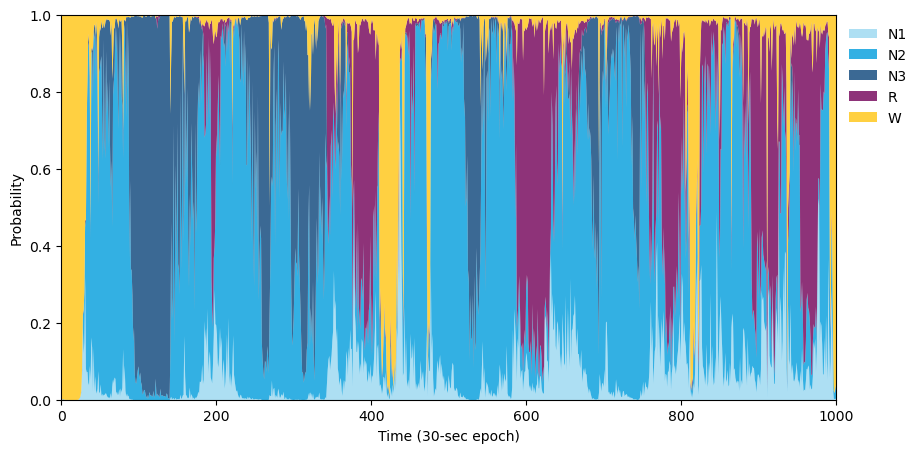

In [9]:
# Plot the predicted probabilities
sls.plot_predict_proba();

In [23]:
# From the probabilities, we can extract a confidence level (ranging from 0 to 1) for each epoch.
confidence = sls.predict_proba().max(1)
confidence

epoch
0      0.997957
1      0.998136
2      0.997209
3      0.998441
4      0.999642
         ...   
995    0.819938
996    0.975818
997    0.981282
998    0.959281
999    0.979840
Length: 1000, dtype: float64

**Exporting to a CSV file**

In [53]:
# Let's first create a dataframe with the predicted stages and confidence
df_pred = pd.DataFrame({'Stage': y_pred, 'Confidence': confidence})
df_pred.head(6)

# Now export to a CSV file
# df_pred.to_csv("my_hypno.csv")
df_pred['Dreem'] = hypno


In [60]:
def replace_noisy_epochs(sleep_stages):
    noisy_count = 0
    for i in range(len(sleep_stages)):
        if sleep_stages[i] != sleep_stages[i]:  # Check if current epoch is NaN
            if i == 0:
                sleep_stages[i] = 0  # First epoch is NaN, set value to 0
            else:
                if sleep_stages[i-1] == sleep_stages[i-1]:  # Check if previous epoch is not NaN
                    sleep_stages[i] = sleep_stages[i-1]  # Set value to previous epoch
                else:
                    sleep_stages[i] = 0  # Set value to 0 if previous epoch is also NaN
                noisy_count += 1
                if noisy_count > 10:
                    sleep_stages[i] = 0  # More than 10 consecutive NaN epochs, set value to 0
        else:
            noisy_count = 0  # Reset noisy count if current epoch is not NaN

    return sleep_stages

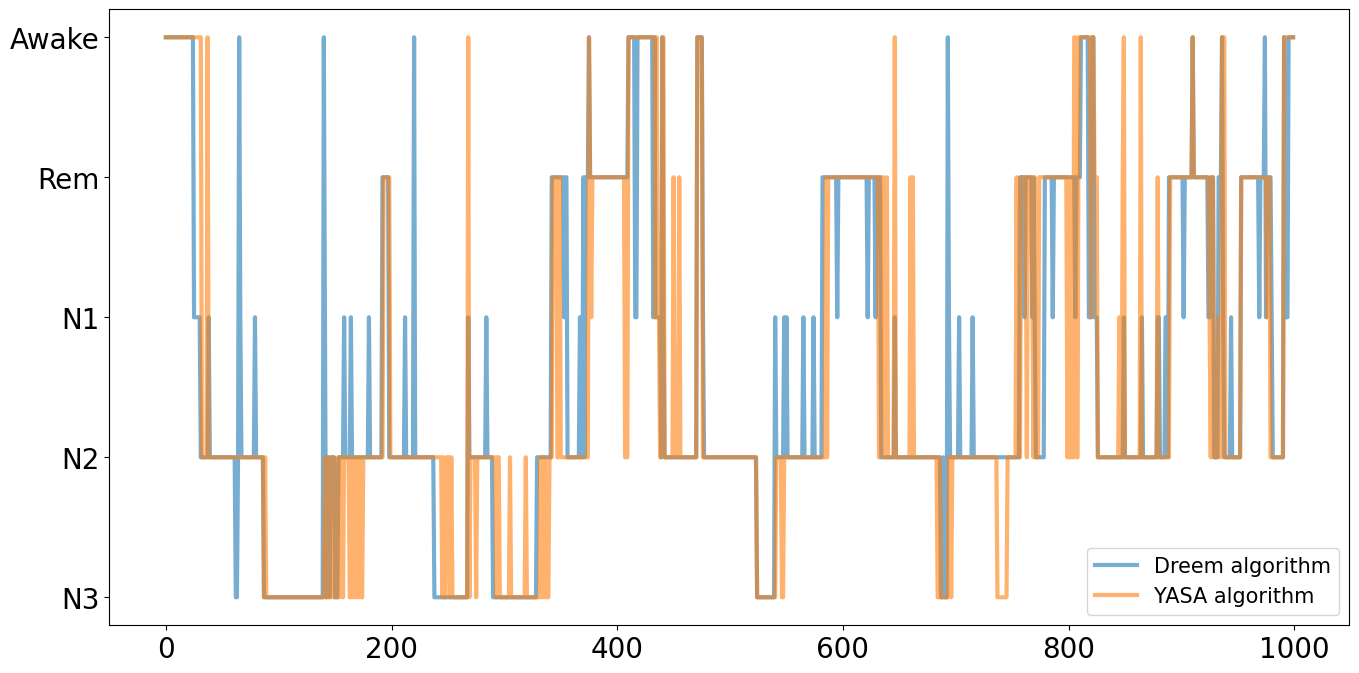

In [66]:
df_pred.replace({'W':0,'N1':1,'N2':2,'N3':3,'R':5}, inplace=True)
df_pred.Dreem = replace_noisy_epochs(df_pred.Dreem)

df_comp = df_pred

df_comp.replace({1:-2,2:-3,3:-4,5:-1},inplace=True)

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df_comp['Dreem'],label='Dreem algorithm',alpha=0.6, lw=3)
ax.plot(df_comp['Stage'],label='YASA algorithm',alpha=0.6, lw=3)
ax.set_yticks(np.arange(-4,1,1),['N3','N2','N1','Rem','Awake']);

ax.legend(fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=20)



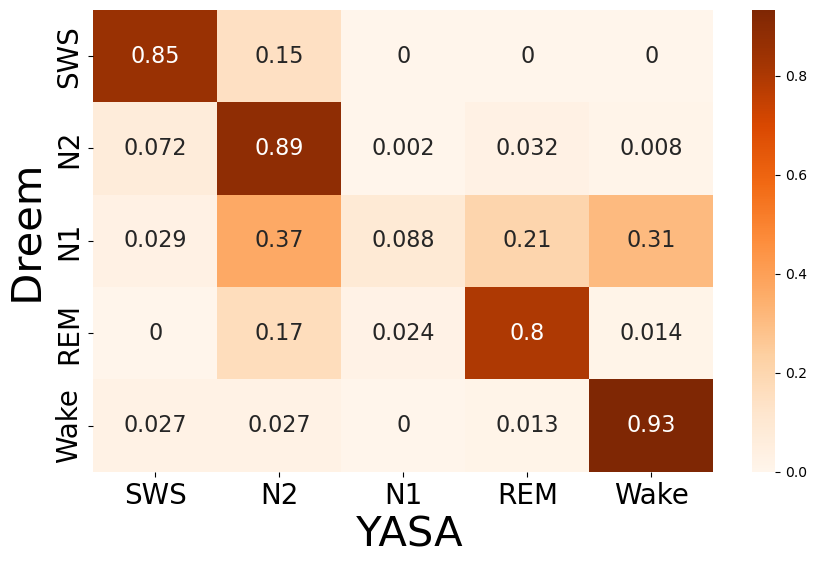

In [67]:
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

df_comp[['Dreem', 'Stage']]

y_test = df_comp['Dreem']
predic = df_comp['Stage']

columns = ['%s' %(i) for i in list(['SWS', 'N2','N1', 'REM','Wake'])[0:len(np.unique(y_test))]]

confm = confusion_matrix(y_test, predic)
confm = confm.astype('float') / confm.sum(axis=1)[:, np.newaxis]

df_cm = DataFrame(confm, index=columns, columns=columns)

fig, ax = plt.subplots(figsize=(10,6))


ax = sn.heatmap(df_cm, cmap='Oranges', annot=True,annot_kws={"size": 16})#, #annot_kws=15)
plt.ylabel(' Dreem',fontsize=30)
plt.xlabel(' YASA', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)


In [48]:
np.unique(y_test)

array([-4, -3, -2, -1,  0])

**Applying the detection using only a single EEG derivation**